# Implementing Sentiment Analysis models

## Installing and importing the necessary packages

In [5]:
%pip install -U textblob
!python -m textblob.download_corpora
%pip install -U scikit-learn
%pip install --upgrade scikit-learn

#!conda install -c conda-forge textblob

Requirement already up-to-date: textblob in d:\programdata\anaconda3\lib\site-packages (0.15.3)
Note: you may need to restart the kernel to use updated packages.
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to

Requirement already up-to-date: scikit-learn in d:\programdata\anaconda3\lib\site-packages (0.24.2)
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: scikit-learn in d:\programdata\anaconda3\lib\site-packages (0.24.2)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import re
import pandas as pd
import numpy as np
import sklearn
import nltk

nltk.download(['wordnet', 'punkt', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## First classifier: TextBlob
> TextBlob is the quickest and easiest way to build a NLP model for sentiment analysis

### Train-test split and text cleansing

In [7]:
dataset = pd.read_csv('datasets/movie_reviews.tsv', delimiter='\t')[:2000]

In [8]:
from sklearn.model_selection import train_test_split

X, y = dataset['review'], dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

#this is only necessary for formatting into a tuple shape to train the TextBlob classifiers
X_train2 = X_train.values.reshape(len(X_train), 1)
y_train2 = y_train.values.reshape(len(y_train), 1)

#tuple form: (X_train, y_train)
train_tuple = list(map(lambda x: (x[0], x[1]), np.hstack((X_train2, y_train2))))

#### Removing punctuation marks and HTML tags

In [9]:

def clean_text(raw_text):
    clean = re.compile("<.*?>|([^A-Za-z'])|('s)")
    cleantext = re.sub(clean, ' ', raw_text)
    cleantext = " ".join(re.split('[!?\., ]', cleantext))
    cleantext = re.sub(r'\s+', ' ', cleantext)
    cleantext = re.sub("\s\W+\s", ' ', cleantext)
    return cleantext

#apply cleansing to all of the texts
train_tuple = list(map(lambda x: (clean_text(x[0]), x[1]), train_tuple))

print(train_tuple[0:1]) #print example

[("I watched the first minutes thinking it was a real documentary with an irritatingly overly dramatic on camera producer When I realized it was all staged I thought why would I want to waste my time watching this junk So I turned it off and came online to warn other people The characters don't act in a believable way too much immature emotion for a guy to travel half way around the world into a war torn country he acted like a kid and I don't believe it was because his character was so upset about the trade center bombings very trite and stupid have you seen city of lost children french dark fantasy film about a guy who kidnaps kids and steals their dreams I liked it ", 0)]


#### Training the model with NB Classifier from TextBlob

In [10]:
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier, DecisionTreeClassifier

cl1 = NaiveBayesClassifier(train_tuple)

**Optional:** save model in file to avoid retraining it each time you open this notebook

In [11]:
import joblib 

#joblib.dump(cl1, 'nbclassifier.joblib') SAVE MODEL
#cl1 = load('nbclassifier.joblib') LOAD MODEL

#### Classify each text and store the results in 1D-array to extract metrics afterwards

In [12]:
def classify(clf):
    y_pred = []
    for text in X_test:
        y_pred.append(clf.classify(text))
        
    return y_pred
        
y_pred1 = np.array(classify(cl1))

              precision    recall  f1-score   support

    positive       0.83      0.79      0.81       251
    negative       0.80      0.84      0.82       249

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



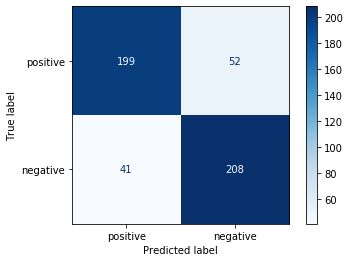

In [13]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
disp.plot(cmap='Blues') 

cr = classification_report(y_test, y_pred1, target_names=['positive', 'negative'])
print(cr)

## Building our own classifiers with Sci-Kit Learn

### Text preprocessing

In [14]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#auxiliar functions
def remove_stopwords(text):
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')

    negation = False
    result = []
    delims = "?.,!:; "
    
    # no permitimos que las negaciones sean borradas de los textos
    for word in text.split():
        stripped = word.strip(delims).lower()
        negated = "not " + stripped if negation else stripped
        negated = re.sub("n\'t", " not", stripped)
        negated = re.sub("'ve", " have", stripped)
        result.append(negated)
        
        if any(neg in word for neg in ["not", "n't", "no"]):
            negation = not negation

        if any(c in word for c in delims):
            negation = False

    text = [word for word in result if not word in set(all_stopwords)]
    text = ' '.join(text)

    return text.lower()

def wordnet_tag(text):
    
    #extrae el tag de wordnet del string devuelto por nltk.pos_tag
    if text.startswith('J'):
        return wordnet.ADJ
    elif text.startswith('V'):
        return wordnet.VERB
    elif text.startswith('N'):
        return wordnet.NOUN
    elif text.startswith('R'):
        return wordnet.ADV
    else:          
        return None


def lemmatize_text(text):

    lem = WordNetLemmatizer()
    tag_text = nltk.pos_tag(nltk.word_tokenize(text))
    text = map(lambda x: (x[0], wordnet_tag(x[1])), tag_text)
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lem.lemmatize(word, tag))

    return " ".join(lemmatized_sentence)

#actual function we're going to use
def preprocess_text(text):
    text = remove_stopwords(text)
    text = clean_text(text)
    text = lemmatize_text(text)
    
    return text

### Building the corpus

In [15]:
corpus = []
for rev in dataset['review']:
    rev = preprocess_text(rev)
    corpus.append(rev)

### Building the dataset with TF-IDFVectorizer
> This is a better way for sentiment analysis than just doing a CountVectorizer in Bag of Words model

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(max_features=2500)
X = tf.fit_transform(corpus).toarray()
y = dataset['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(len(tf.get_feature_names()))

2500


### Trying Bayesian algorithms

#### Plotting ROC-AUC curves

Text(0.5, 0.98, 'ROC curve comparison')

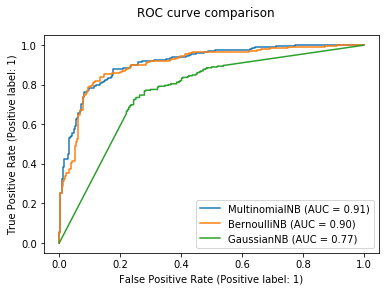

In [17]:
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

bnb = BernoulliNB()
bnb.fit(X_train, y_train)

mnb_disp = plot_roc_curve(mnb, X_test, y_test)
bnb_disp = plot_roc_curve(bnb, X_test, y_test, ax=mnb_disp.ax_)
gnb_disp = plot_roc_curve(gnb, X_test, y_test, ax=mnb_disp.ax_)
gnb_disp.figure_.suptitle("ROC curve comparison")

#### Metrics and confusion matrices

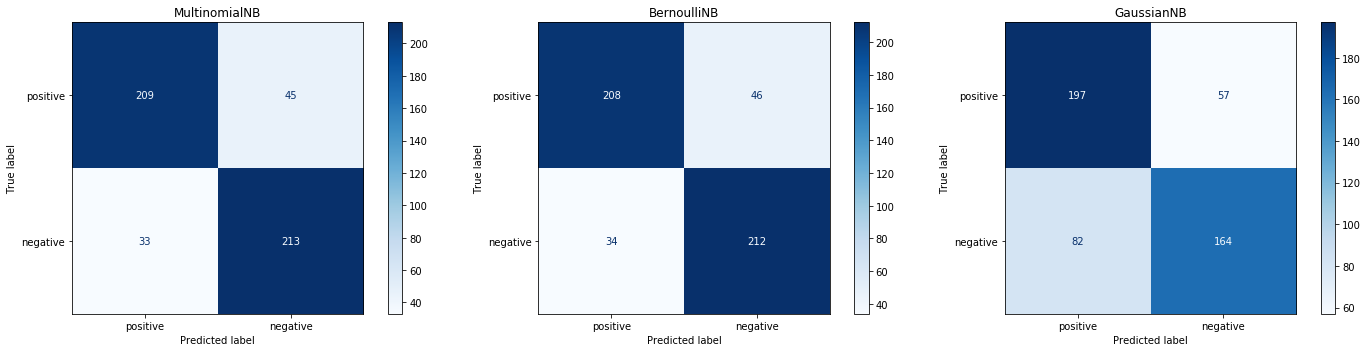

In [18]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

classifiers = [mnb, bnb, gnb]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues',display_labels=['positive', 'negative'])
    ax.title.set_text(type(cls).__name__)
    plt.tight_layout()  

plt.show()

In [19]:
from sklearn.metrics import classification_report

for cls in classifiers:
    y_pred = cls.predict(X_test)
    cr = classification_report(y_test, y_pred, target_names=['positive', 'negative'])
    print('********\t' + type(cls).__name__ + '\t********\n')
    print(cr)

********	MultinomialNB	********

              precision    recall  f1-score   support

    positive       0.86      0.82      0.84       254
    negative       0.83      0.87      0.85       246

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

********	BernoulliNB	********

              precision    recall  f1-score   support

    positive       0.86      0.82      0.84       254
    negative       0.82      0.86      0.84       246

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

********	GaussianNB	********

              precision    recall  f1-score   support

    positive       0.71      0.78      0.74       254
    negative       0.74      0.67      0.70       246

    accuracy                           0.72       500
   macro avg       0.72      0.72 

### Non-bayesian algorithms

#### Plotting ROC-AUC curves

Text(0.5, 0.98, 'ROC curve comparison')

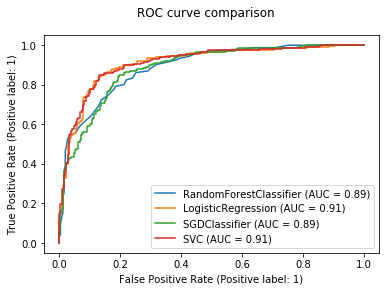

In [20]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=100, random_state = 1)
rf.fit(X_train, y_train)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

sgd = SGDClassifier(random_state = 1)
sgd.fit(X_train, y_train)

svc = SVC(kernel='rbf', random_state = 1)
svc.fit(X_train, y_train)

rf_disp = plot_roc_curve(rf, X_test, y_test)
lr_disp = plot_roc_curve(lr, X_test, y_test, ax=rf_disp.ax_)
sgd_disp = plot_roc_curve(sgd, X_test, y_test, ax=rf_disp.ax_)
svc_disp = plot_roc_curve(svc, X_test, y_test, ax=rf_disp.ax_)
svc_disp.figure_.suptitle("ROC curve comparison")

#### Metrics and confusion matrices

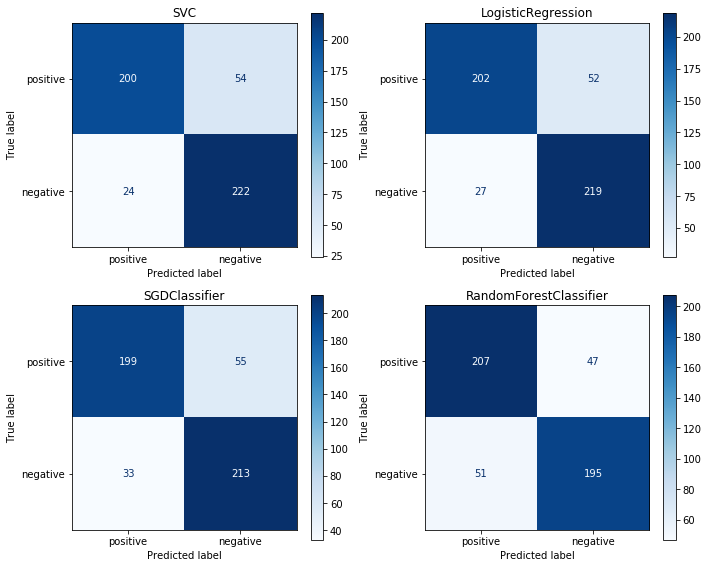

In [21]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

classifiers = [svc, lr, sgd, rf]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues',display_labels=['positive', 'negative'])
    ax.title.set_text(type(cls).__name__)
    plt.tight_layout()  

plt.show()

In [22]:
from sklearn.metrics import classification_report

for cls in classifiers:
    y_pred = cls.predict(X_test)
    cr = classification_report(y_test, y_pred, target_names=['positive', 'negative'])
    print('********\t' + type(cls).__name__ + '\t********\n')
    print(cr)

********	SVC	********

              precision    recall  f1-score   support

    positive       0.89      0.79      0.84       254
    negative       0.80      0.90      0.85       246

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500

********	LogisticRegression	********

              precision    recall  f1-score   support

    positive       0.88      0.80      0.84       254
    negative       0.81      0.89      0.85       246

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500

********	SGDClassifier	********

              precision    recall  f1-score   support

    positive       0.86      0.78      0.82       254
    negative       0.79      0.87      0.83       246

    accuracy                           0.82       500
   macro avg       0.83      0.82 

### Final decision: cross validation and Grid Search
> We'll take the final test by comparing cross validation on different classifiers (bayesian and non-bayesian), and make hyper-parameter tuning on the best one with GridSearchCV

#### Cross validation on multiple models
> **Warning** This steps can take a little long to run. Grid search is a very compute intensive task with so many features and rows

In [27]:
from sklearn.model_selection import cross_val_score

cv_scores = []
classifiers = [svc, lr, sgd, rf, mnb]

print('Cross validation accuracies (means)')
for cls in classifiers:
    scores = cross_val_score(cls, X_train, y_train, cv=10, scoring='accuracy', n_jobs = -1) # Stratified 10-fold cross validation
    print('-> ' + type(cls).__name__ + ': {:.2f}%'.format(round(scores.mean()*100, 2)))

Cross validation accuracies (means)
-> SVC: 82.80%
-> LogisticRegression: 82.67%
-> SGDClassifier: 79.33%
-> RandomForestClassifier: 80.60%
-> MultinomialNB: 81.00%


#### Grid Search on SVC  (best model)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = [{'C': [1, 10, 100], 'kernel': ['linear', 'poly']},
              {'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}]

grid_search = GridSearchCV(SVC(), parameters, scoring='accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)

print("Best Accuracy: {:.2f} %".format(grid_search.best_score_*100))
print("Best Parameters:", grid_search.best_params_)

Best Accuracy: 82.80 %
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


#### Grid Search on Logistic Regression

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {'solver': ['saga', 'liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.5, 1.0, 2.0, 10.0]}

grid_search2 = GridSearchCV(LogisticRegression(), parameters, scoring='accuracy', cv = 10, n_jobs = -1)
grid_search2.fit(X_train, y_train)

print("Best Accuracy: {:.2f} %".format(grid_search2.best_score_*100))
print("Best Parameters:", grid_search2.best_params_)

Best Accuracy: 82.80 %
Best Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


**More efficient Grid Search**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

parameters = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}

svc = SVC(kernel='rbf', cache_size = 1000, probability=False)

rand = RandomizedSearchCV(svc, parameters, scoring='accuracy', cv=3, n_jobs=-1)
rand.fit(X_train, y_train)

print("Best Accuracy: {:.2f} %".format(rand.best_score_*100))
print("Best Parameters:", rand.best_params_)

## Retraining and exporting the winner model with the best parameters

In [9]:
from sklearn.svm import SVC
import joblib

svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train, y_train)

joblib.dump(svc, 'svcmodel.joblib') #SAVE MODEL
joblib.dump(tf, 'tfidf.joblib')

ValueError: could not convert string to float: 'I watched the first 15 minutes, thinking it was a real documentary (with an irritatingly overly dramatic \\on camera\\" producer).<br /><br />When I realized it was all staged I thought \\"why would I want to waste my time watching this junk??\\" So I turned it off and came online to warn other people. The characters don\'t act in a believable way. too much immature emotion. for a guy to travel half way around the world into a war torn country, he acted like a kid. and I don\'t believe it was because \\"his character was so upset about the trade center bombings\\".<br /><br />very trite and stupid.<br /><br />have you seen \\"city of lost children\\"? french dark fantasy film about a guy who kidnaps kids and steals their dreams... I liked it!"'